In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# 1. Load data & EDA (Before Preprocessing)

In [60]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [61]:
print("The shape of train data: ", train.shape)
print(" ")
train.info()

The shape of train data:  (7613, 5)
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [62]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [63]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('darkgrid')

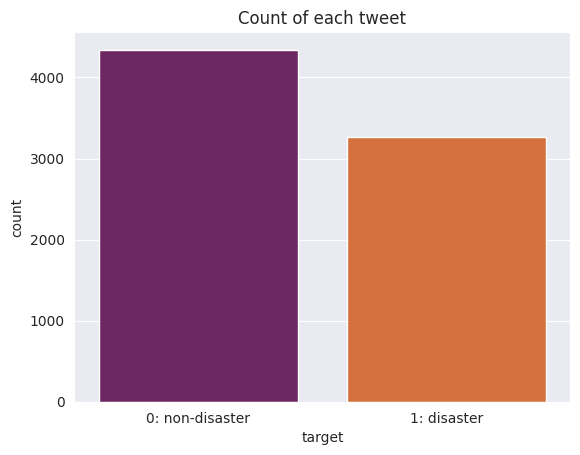

In [64]:
target_count = train['target'].value_counts()
sns.barplot(x=target_count.index, y=target_count, palette='inferno')
plt.title('Count of each tweet')
plt.xticks(ticks=[0, 1], labels=['0: non-disaster', '1: disaster'])
plt.show()


In [65]:
#Let's find which words were mentioned more

#From all the tweets
top20_keyword = train['keyword'].value_counts().head(20)
#From the disaster tweets
top20_keyword_disaster = train[train['target'] == 1]['keyword'].value_counts().head(20)
#From the non-disaster tweets
top20_keyword_nodisaster = train[train['target'] == 0]['keyword'].value_counts().head(20)

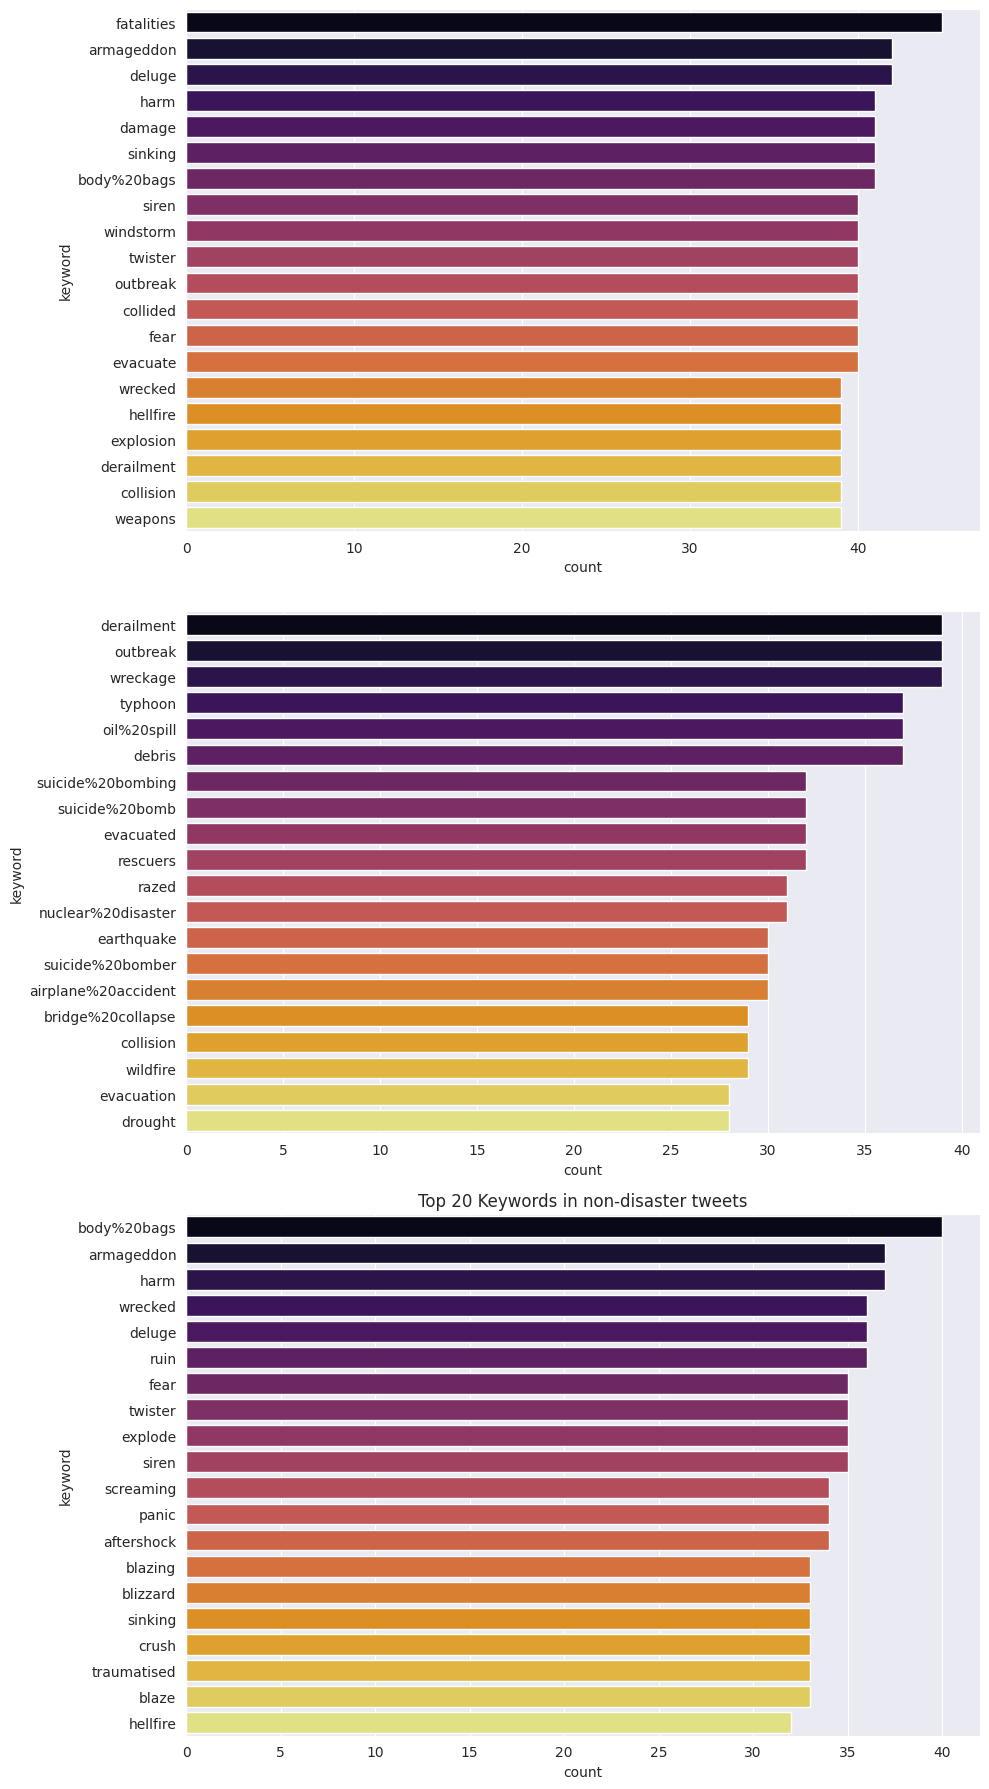

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(10,18))

#From all the tweets
sns.barplot(x=top20_keyword, y=top20_keyword.index, palette='inferno', ax=axes[0])
plt.title('Top 20 Keywords')

#From the disaster tweets
sns.barplot(x=top20_keyword_disaster, y=top20_keyword_disaster.index, palette='inferno', ax=axes[1])
plt.title('Top 20 Keywords in disaster tweets')

#From the non-disaster tweets
sns.barplot(x=top20_keyword_nodisaster, y=top20_keyword_nodisaster.index, palette='inferno', ax=axes[2])
plt.title('Top 20 Keywords in non-disaster tweets')

#adjust space automatically
plt.tight_layout()

plt.show()

In [67]:
#Let's find where the tweets were posted more

#From all the tweets
top10_location = train['location'].value_counts().head(10)
#From the disaster tweets
top10_location_disaster = train[train['target'] == 1]['location'].value_counts().head(10)
#From the non-disaster tweets
top10_location_nodisaster = train[train['target'] == 0]['location'].value_counts().head(10)

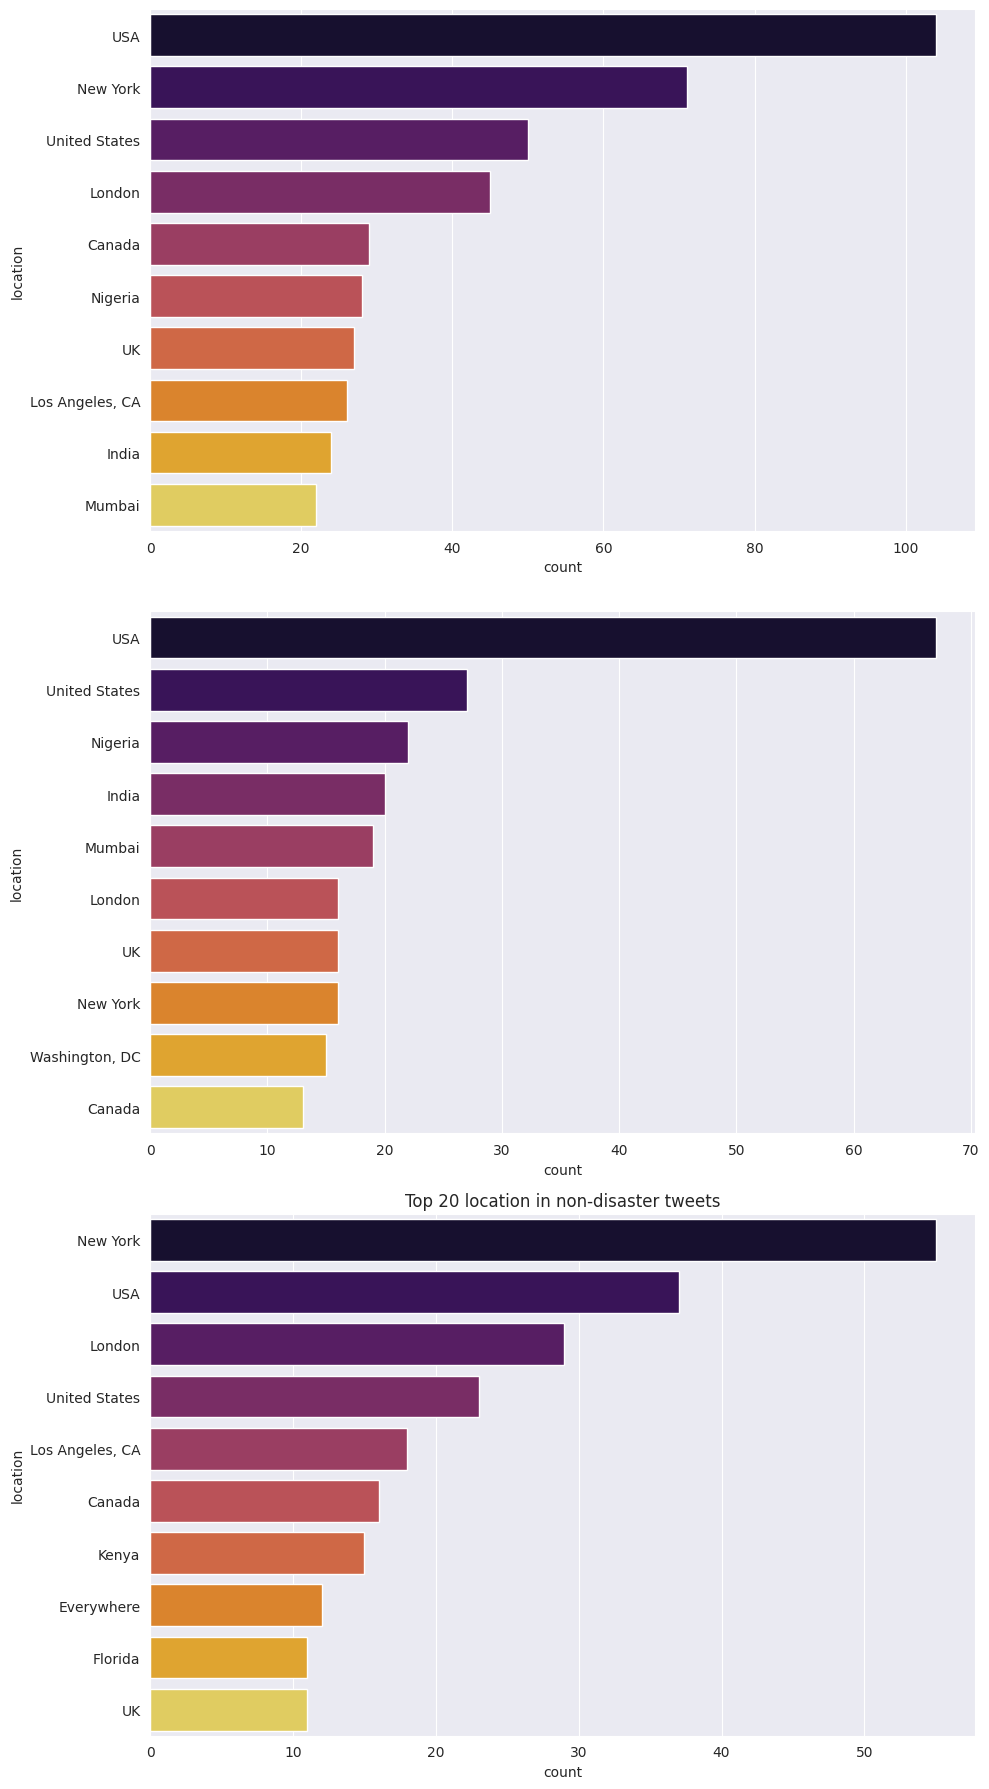

In [68]:
fig, axes = plt.subplots(3,1, figsize=(10,18))

#From all tweets
sns.barplot(x=top10_location, y=top10_location.index, palette='inferno', ax=axes[0])
plt.title('Top 10 location')

#From the disaster tweets
sns.barplot(x=top10_location_disaster, y=top10_location_disaster.index, palette='inferno', ax=axes[1])
plt.title('Top 20 location in disaster tweets')


#From the non-disaster tweets
sns.barplot(x=top10_location_nodisaster, y=top10_location_nodisaster.index, palette='inferno', ax=axes[2])
plt.title('Top 20 location in non-disaster tweets')

plt.tight_layout()

plt.show()

In [69]:
#Let's check how long the tweets are

#Length
txt_length = [len(text) for text in train['text']]
txt_length_disaster = [len(text) for text in train[train['target']==1]['text']]
txt_length_nodisaster = [len(text) for text in train[train['target']==0]['text']]

print(f"The maximum length of tweets from all tweets: {max(txt_length)}")
print(f"The maximum length of tweets from disaster tweets: {max(txt_length_disaster)}")
print(f"The maximum length of tweets from non-disaster tweets: {max(txt_length_nodisaster)}")

The maximum length of tweets from all tweets: 157
The maximum length of tweets from disaster tweets: 151
The maximum length of tweets from non-disaster tweets: 157


In [70]:
#Average
avg_txt_length = round(sum(txt_length) / len(txt_length), 2)
avg_txt_length_disaster = round(sum(txt_length_disaster) / len(txt_length_disaster), 2)
avg_txt_length_nodisaster = round(sum(txt_length_nodisaster) / len(txt_length_nodisaster) ,2)

print(f"The average length of tweets from all tweets: {avg_txt_length}")
print(f"The average length of tweets from disaster tweets: {avg_txt_length_disaster}")
print(f"The average length of tweets from non-disaster tweets: {avg_txt_length_nodisaster}")

The average length of tweets from all tweets: 101.04
The average length of tweets from disaster tweets: 108.11
The average length of tweets from non-disaster tweets: 95.71


**From this rough EDA we can tell**
- non-disaster tweets are posted more than disaster tweets
- All keywords appeared frequently from 3 aspects are the words giving negative feelings even in the non-disaster tweets
- The location doesn't have rule as we can see there are names of country, states, city, etc.
- In general, the disaster tweets is longer than others

# 2. Data Cleaning & Text Preprocessing

## 2.1 Data Cleaning

In [71]:
#find duplicated data
duplicated_data = train[train.duplicated(subset=['text'])]
duplicated_data

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [72]:
print(f"raw data: {len(train)}")

train.drop_duplicates(subset=['text'], inplace=True)
print(f"after removing duplicated data: {len(train)}")

raw data: 7613
after removing duplicated data: 7503


In [73]:
train.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


In [74]:
train.isna().sum()

text      0
target    0
dtype: int64

## 2.2 Text Preprocessing

In [75]:
#remove punctuation and other characters
import re

def Remove_special_character(text):
    special_char = r'[^a-zA-Z0-9\s]'
    cleaned_text = re.sub(special_char,'',text)
    return cleaned_text

train['text'] = train['text'].apply(lambda x: Remove_special_character(x))

train['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7604    WorldNews Fallen powerlines on Glink tram UPDA...
7605    on the flip side Im at Walmart and there is a ...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7503, dtype: object

In [76]:
#Change all text to lowercase
def Change_to_lower(text):
    lower_data = text.lower()
    return lower_data

train['text'] = train['text'].apply(lambda x: Change_to_lower(x))

train['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7604    worldnews fallen powerlines on glink tram upda...
7605    on the flip side im at walmart and there is a ...
7606    suicide bomber kills 15 in saudi security site...
7608    two giant cranes holding a bridge collapse int...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7503, dtype: object

In [77]:
#remove stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def Remove_stopwords(text):
    tokens = word_tokenize(text) #tokenize before remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens) #merge again
            
train['text'] = train['text'].apply(lambda x: Remove_stopwords(x))
train['text']

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7604    worldnews fallen powerlines glink tram update ...
7605    flip side im walmart bomb everyone evacuate st...
7606    suicide bomber kills 15 saudi security site mo...
7608    two giant cranes holding bridge collapse nearb...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7503, dtype: object

# 3. Vectorization

In [78]:
X_data = train['text']
y_data = train['target']
print(len(X_data))
print(len(y_data))

7503
7503


In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [80]:
#Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15,
                                                    random_state=42, stratify=y_data)

In [81]:
#Tokenize, encoding
tokenizer = Tokenizer(oov_token="<OOV>")
#create word set based on word freq
tokenizer.fit_on_texts(X_train)
#get sequence of text as digits
X_train_encoded = tokenizer.texts_to_sequences(X_train)

print(X_train_encoded[:5])

[[5864, 3823, 270], [183, 19, 1147, 317, 2316], [156, 1148, 5865, 318, 228, 1511, 5866], [562, 40, 5867, 5868, 48, 536], [5869, 5870, 54, 5871, 1053, 5872, 5873, 1367, 1957, 240, 2906, 2907, 897]]


In [82]:
#Let's see the pair of word and digit
word_to_index = tokenizer.word_index

count = 0
for word, idx in word_to_index.items():
    if count >= 10:
        break
    print(f"{word}: {idx}")
    count += 1

<OOV>: 1
like: 2
im: 3
amp: 4
fire: 5
get: 6
via: 7
new: 8
dont: 9
people: 10


In [83]:
#Let's see the size of vocab
vocab_size = len(word_to_index) + 1 #1 is for padding digit
vocab_size

19898

In [84]:
#Padding
#max length of tweet
max(len(text) for text in X_train_encoded)

25

In [85]:
maxlen = max([len(seq) for seq in X_train_encoded])
X_train_padded = pad_sequences(X_train_encoded, maxlen=maxlen)
X_train_padded.shape

(6377, 25)

# 4. Modeling RNN

In [145]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential

embedding_dim=200

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [146]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32,
                    validation_split=0.15, callbacks=[early_stopping, model_checkpoint])


Epoch 1/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - binary_accuracy: 0.6710 - loss: 0.5946 - val_binary_accuracy: 0.7889 - val_loss: 0.4505
Epoch 2/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9150 - loss: 0.2185 - val_binary_accuracy: 0.7795 - val_loss: 0.5142
Epoch 3/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9761 - loss: 0.0679 - val_binary_accuracy: 0.7847 - val_loss: 0.7257
Epoch 4/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9923 - loss: 0.0242 - val_binary_accuracy: 0.7847 - val_loss: 0.8022


In [147]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen=maxlen)

model.evaluate(X_test_padded, y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7968 - loss: 0.4555


[0.43687745928764343, 0.8037300109863281]

In [148]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.round(model.predict(X_test_padded))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[577  69]
 [152 328]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       646
           1       0.83      0.68      0.75       480

    accuracy                           0.80      1126
   macro avg       0.81      0.79      0.79      1126
weighted avg       0.81      0.80      0.80      1126



# Analysis of Results

## Class 0 (Negative Class):

- The model demonstrates strong performance in predicting non-disaster tweets, with a high recall of **0.89** and precision of **0.79**. This means that the model is highly effective at correctly identifying most negative instances, with few false positives.
- The F1-score of **0.84** indicates a good balance between precision and recall for this class.

## Class 1 (Positive Class):

- The model has a high precision of **0.83** for disaster-related tweets, meaning that when it predicts a tweet as disaster-related, it is correct 83% of the time. However, the recall is lower at **0.68**, suggesting that the model misses some disaster-related tweets.
- The F1-score for this class is **0.75**, indicating a decent balance but with room for improvement in recall.

## Overall Performance:

- The macro and weighted averages of precision, recall, and F1-score are around **0.80**, demonstrating that the model maintains a consistent performance across both classes.
- The slight imbalance in recall between the two classes suggests that the model is more conservative in predicting disaster-related tweets, which may be beneficial depending on the use case, such as minimizing false positives in critical scenarios.

## Conclusion

The model exhibits robust performance with a solid accuracy of **80%** on the test set. It effectively identifies non-disaster tweets but could benefit from further optimization to improve recall for disaster-related tweets. Overall, the model is well-balanced and suitable for text classification tasks involving binary labels, with potential areas for fine-tuning to enhance recall for positive classes.


# 5. Apply model to test data for submission

In [149]:
#apply model to test data
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [150]:
test = test.drop(['id', 'location', 'keyword'], axis=1)

In [151]:
tweet = test['text']
tweet_encoded = tokenizer.texts_to_sequences(tweet)
tweet_padded = pad_sequences(tweet_encoded, maxlen=maxlen, padding='post')

tweet_padded.shape

(3263, 25)

In [152]:
y_pred = model.predict(tweet_padded)
y_pred = [1 if i>0.5 else 0 for i in y_pred]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [153]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = y_pred
submission.to_csv("submission.csv", index=False)

### References
https://www.kaggle.com/competitions/nlp-getting-started